In [1]:
#%% load library
import numpy as np
from scipy.spatial import distance_matrix
from scipy.integrate import solve_ivp
from pyunicorn.timeseries import surrogates
from scipy.stats import pearsonr
# import ccm
import matplotlib.pyplot as plt
#from mpi4py.futures import MPIPoolExecutor

pyunicorn: Package netCDF4 could not be loaded. Some functionality in class Data might not be available!
pyunicorn: Package netCDF4 could not be loaded. Some functionality in class NetCDFDictionary might not be available!


In [2]:
#%% Create dataset
#%%% Lotka Volterra
def lotkaVolterra(t,y,mu,M):
    return y * (mu + M @ y);

def lotkaVolterraSat(t,y,mu,M,K):    
    intx_mat = M/(K + y);
    lv = y * (mu + intx_mat @ y);
    return lv;

# Originally Caroline return tested results. Linh modified to only generate ts
def generate_lv(run_id, dt_s, N, noise,noise_T,intx="competitive"):
    dt=0.05;
    mu = np.array([0.7,0.7]);
    M = np.zeros((2,2));
    fn = lotkaVolterra;
    if (intx=="competitive"):
        M = [[-0.4,-0.5],[-0.5,-0.4]];
        args=(mu,M)
    if (intx=="asym_competitive"):
        M = [[-1.4,-0.5],[-0.9,-1.4]];
        mu = [0.8,0.8];
        args=(mu,M);
    elif (intx=="mutualistic"):
        M = [[-0.4,0.3],[0.3,-0.4]];
        args=(mu,M)
    elif (intx=="saturable"):     
        M = np.array([[-10.,0.3],[1.,-10.]]);
        K = np.array([[100.,10.],[20.,100.]]) 
        args=(mu,M,K)
        fn = lotkaVolterraSat;
    elif (intx=="predprey"):              
        mu = np.array([1.1,-0.4])
        M = np.array([[0.0,-0.4],[0.1,0.0]]);
        args=(mu,M)
    sample_period = int(np.ceil(dt_s / dt));
    
    lag = int(150/dt);
    obs = sample_period * N;

    #if run_id % 100 == 0:
    print("test " + str(run_id) + " starting");
    s = np.zeros((lag + obs + 1, 2))
    s[0] = [1.,1.]
    for i in range(lag + obs):
        soln = solve_ivp(fn,[0,dt],s[i],args=args)
        eps = noise*np.random.randn(2)*np.random.binomial(1,dt/noise_T,size=2);
        s[i+1] = soln.y[:,-1] + eps;
        s[i+1][np.where(s[i+1] < 0)] = 0;

    x = s[lag::sample_period,];
    for i in range(x.ndim):
        x[:,i] += 0.001*np.random.randn(x[:,i].size);

    if run_id % 100 == 0:
        print("test " + str(run_id) + " finished");
        
    # plt.plot(x)
    return x
    
    # return test_with_surr(x.reshape(-1,1));

#%%% AR model for control
def ar_control(noise=1.0):
    x = np.zeros(601);
    for i in range(600):
        x[i+1] = 0.8*x[i] + noise*np.random.randn();
      
    x = x[100:];
    # null = get_iaaft_surr(x,num_surr=99);
    # pred_err_null = pred_error(null,2,1);
    
    # pred_err_true = pred_error(x.reshape(-1,1), 2, 1)

    # pred_err_null = np.append(pred_err_null, pred_err_true)
    
    # return np.mean(pred_err_null >= pred_err_true)
    return x


#%%% Chemical mediated model
# diffeq
def dSCdt(SC, num_spec, r0, K, alpha, beta, rho_plus, rho_minus):
    """
    Parameters:

    SC (array): an array of species and chemical abundances in which species
        are listed before chemicals
    num_spec (int): number of species
    r0 (2d numpy.array): num_spec x 1 array of intrinsic growth rates
    K (2d numpy.array): num_spec x num_chem array of K values
    alpha (2d numpy.array): num_chem x num_spec array of consumption constants
    beta (2d numpy.array): num_chem x num_spec array of production constants
    rho_plus (2d numpy.array): num_spec x num_chem array of positive influences
    rho_minus (2d numpy.array): num_spec x num_chem array of negative influences
    """

    S = np.reshape(SC[:num_spec], [num_spec,1])
    C = np.reshape(SC[num_spec:], [len(SC) - num_spec, 1])
    # compute K_star
    K_star = K + C.T
    # compute K_dd
    K_dd = rho_plus * np.reciprocal(K_star)
    # compute lambda
    Lambda = np.matmul(K_dd - rho_minus, C) #According to the manuscript we would have (K_dd - rho_minus/K)*C
    # compute dS/dt
    S_prime = (r0 + Lambda) * S
    # compute K_dag
    C_broadcasted = np.zeros_like(K.T) + C
    K_dag = np.reciprocal(C_broadcasted + K.T) * C_broadcasted # Why calculate C_broadcasted instead of using C
    # compute dC/dt
    C_prime = np.matmul(beta - (alpha * K_dag), S)
    SC_prime = np.vstack((S_prime, C_prime))
    return SC_prime

#for chemically mediated interactions (add constant rsrc flux)
def sc_prime_rsrc(t, y, num_spec, r0, K, alpha, beta, rho_plus, rho_minus,r_flux):
    dy = dSCdt(y, num_spec, r0, K, alpha, beta, rho_plus, rho_minus);
    dy[-1] += r_flux;
    return np.reshape(dy, dy.size).tolist()

# Caroline sent: run nonlinearity test, Linh modified to only generate ts
def generate_niehaus(run_id, dt_s, N, noise, noise_T, intx="competitive"):
    dt=0.05;
    sample_period = int(np.ceil(dt_s / dt));
    
    lag = int(150/dt);
    obs = sample_period * N;
    
    if (intx=="competitive"):
        num_spec = 2
        num_chem = 1
        r0 = np.array([[-1.6],
                       [-1.6]])
        K = np.array([[5.0],
                      [5.0]])
        alpha = np.array([[4.0,4.0]])
        beta = np.array([[0.0,0.0]])
        rho_plus = np.array([[4.8],
                      [4.8]])
        rho_minus = np.zeros((num_spec,num_chem))
        r_flux = 4;
    if (intx=="mutualistic"):
        num_spec = 2
        num_chem = 2
        r0 = np.array([[-2.],[-2.]])
        K = np.array([[5.0,1.0],
                      [1.0,5.0]])
        alpha = np.array([[6.0,0.8],
                          [0.8,6.0]])
        beta = np.array([[0.0,2.0],
                         [2.0,0.0]])
        rho_plus = np.array([[10.0,0.0],
                      [0.0,10.0]])
        rho_minus = np.array([[0.0,0.4],
                              [0.4,0.0]])
        r_flux = 0;
    
    params = (num_spec, r0, K, alpha, beta, rho_plus, rho_minus, r_flux);
    
    if run_id % 100 == 0:
        print("test " + str(run_id) + " starting");
        
    s = np.zeros((lag + obs + 1, num_spec + num_chem))
    s[0] = np.zeros((num_spec + num_chem))
    s[0,:2] = 1;
    
    for i in range(lag + obs):
        soln = solve_ivp(sc_prime_rsrc,[0,dt],s[i],args=params);
        eps = noise*np.random.randn(num_spec + num_chem) * \
            np.random.binomial(1,dt/noise_T,size=num_spec + num_chem);
        s[i+1] = soln.y[:,-1] + eps;
        s[i+1][np.where(s[i+1]<0)] = 0;

    x = s[lag::sample_period,].copy()
    
    if (np.any(x < 2.)):
        print("Crossover?")

    if run_id % 100 == 0:
        print("test " + str(run_id) + " finished");
    
    # return test_with_surr(x.reshape(-1,1));
    return x

test 1 starting
Crossover?


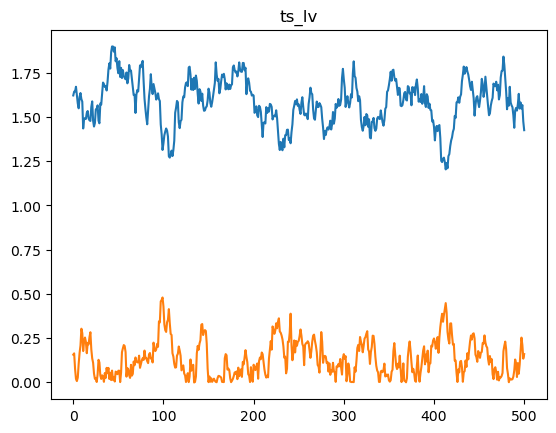

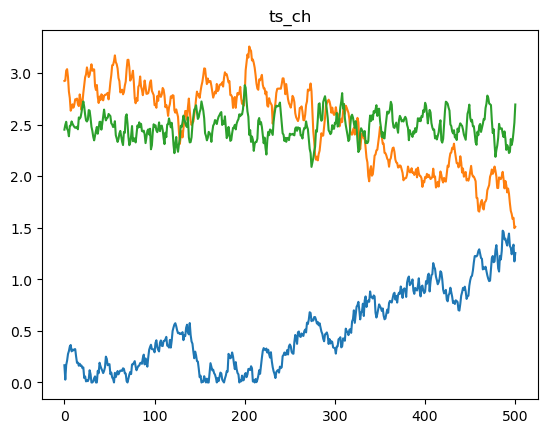

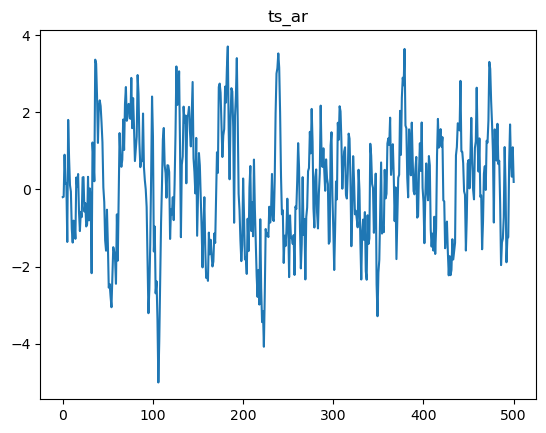

In [3]:
#%% Run
if __name__=="__main__":
    
    N=500;
    noise=0.05*0.5;
    noise_T=0.05;
    dt_s=0.25;
    intx="competitive";
    reps = 1;
    ts_ar = ar_control()
    ts_lv = generate_lv(run_id = 1, dt_s = dt_s, N=N, noise=noise,noise_T=noise_T,intx="competitive")
    ts_ch = generate_niehaus(run_id=1, dt_s=dt_s, N=N, noise=noise, noise_T=noise_T, intx="competitive")
    # func=generate_niehaus
    for x in ['ts_lv', 'ts_ch']:
        ts = globals()[x];
        for i in range(ts.shape[1]):
            plt.plot(ts[:,i])
            plt.title(x)
    # plt.show()
        plt.show()
    plt.plot(ts_ar)
    plt.title("ts_ar")
        
    # print (ts)

In [ ]:
#%% Nonlinearity statistics
#%%% Prediction errors
def pred_error(ts, embed_dim, tau=1, pearson=False):
    
    #normalize time series to have zero mean and unit variance
    ts_norm = (ts - np.mean(ts,axis=0)) / np.std(ts, axis=0)
    
    N = ts_norm.shape[0];
    if (ts_norm.ndim > 1):
        M = ts_norm.shape[1];
    else:
        M = 1;
    #embed time series
    X_array = np.zeros((N - (embed_dim-1)*tau - 1,embed_dim,M));
    for i in range(embed_dim):
        X_array[:,i] = ts_norm[tau*i:(N - (embed_dim-1)*tau + tau*i - 1)];
        
    rms_err = np.zeros(M);
    pcorr = np.zeros(M);
    for j in range(M):
        X = X_array[:,:,j];
        # response variable. one step future of each embed
        X_true = ts_norm[(tau*(embed_dim-1) + 1):,j]; 
        #make list of sorted neighbors
        KX = distance_matrix(X,X); 

        # do not train on itself
        # does this count as loocv?
        np.fill_diagonal(KX, np.inf)  
        nbr = np.argsort(KX); #sorted
        
        err = np.zeros(X.shape[0]);
        X_pred = np.zeros(X.shape[0]);
        
        #estimate each pt
        for i in range(X.shape[0]):
            #X_true[i] = X[i+1,0];
            
            #number of neighbors = embed_dim + 1
            #no distance based weighting
            N_nbrs = embed_dim + 1;
            X_nbrs = nbr[i,:N_nbrs];
            
            X_pred[i] = np.mean(X_true[(X_nbrs).astype(int)]);
            err[i] = (X_true[i] - X_pred[i])**2;
            
        rms_err[j] = np.sqrt(np.mean(err,axis=0))
        pcorr[j] = pearsonr(X_pred, X_true)[0]
    
    if pearson:
        return pcorr;
    else:
        return rms_err;

In [4]:
def vis_data(ts):
    for i in range(ts.shape[1]):
        plt.plot(ts[:,i])

In [6]:
embed_dim=5
tau=3

ts=ts_lv
ts_norm = (ts - np.mean(ts,axis=0)) / np.std(ts, axis=0)
vis_data(ts_norm)

"""Create embed"""
N = ts_norm.shape[0]; #number of time points/observations
if (ts_norm.ndim > 1):
    M = ts_norm.shape[1]; #number of realisations/series
else:
    M = 1;

#embed time series
X_array = np.zeros((N - (embed_dim-1)*tau - 1,embed_dim,M));
for i in range(embed_dim):
    X_array[:,i] = ts_norm[tau*i:(N - (embed_dim-1)*tau + tau*i - 1)];
vis_data(X_array)


In [12]:
"""calculate prediction error"""
rms_err = np.zeros(M);
pcorr = np.zeros(M);

In [14]:
j=1 # or 0
X = X_array[:,:,j];
# response variable. one step future of each embed
X_true = ts_norm[(tau*(embed_dim-1) + 1):,j]; #s_n according to formula
#make list of sorted neighbors
KX = distance_matrix(X,X); 
KX
# do not train on itself
# does this count as loocv?
np.fill_diagonal(KX, np.inf)  
nbr = np.argsort(KX); #sorted
"""sorted in what way???
nbr.shape() = (488,488), 
it sort by the last column, 
print it out and pay attention to the last column, 
all the inf which is the distance between the points themselves 
are put at the last column nbr[:,-1]
Also, it is ascending because the inf is at the bottom 
so the first nbr indices nbr[:,0:(embed_dim+1)] are the neighbors,
which is specified in the below codes
"""

In [32]:
nbr[-1,:]

array([384, 198, 379, 290,  66, 293,  64,  61, 380,  75,  68, 287,  74,
       180, 197, 194,  65,  70,  72, 200,  45,  63, 182,  48, 199, 201,
        71, 426,  76, 271, 351, 428, 354,  62, 383, 378, 363, 390,  82,
       427,  67, 309, 283, 183, 195,  69, 291, 346, 181, 348, 177, 468,
       121, 311,  78, 484, 365,  52, 386, 285,  59,  60,   5,  46,  80,
        47, 425, 292, 289, 369, 486, 179, 347, 205, 308, 353, 286, 124,
       470,  81, 310, 284, 128, 208,  77, 160, 127, 469, 448, 273, 129,
       385, 188, 159,  42, 303, 433, 185, 481,  73, 161,  44,  26, 281,
        49, 176, 174, 430, 350, 434, 349, 277, 110, 352, 307, 432, 203,
       465, 236, 381, 202,  58, 364, 112, 436, 113, 482, 424, 178, 446,
       368, 447, 184,   2, 256, 288,  38, 431, 471,  51, 387, 206, 382,
        79,  41, 237, 376, 272, 377, 306, 278, 167, 296, 186, 392, 483,
       120, 280, 165, 114, 336, 359,  36,  32, 189, 451,  34, 345, 204,
       466,  55, 485, 472, 211, 338, 162,  27, 305, 362,  30, 34

In [ ]:
#estimate each pt
#for i in range(X.shape[0]):
i=100
#X_true[i] = X[i+1,0];

#number of neighbors (N_nbrs) = embed_dim + 1 #N_epsilon=d+1 ##ask Caroline why
#no distance based weighting
N_nbrs = embed_dim + 1; 
X_nbrs = nbr[i,:N_nbrs]; # Explained above

    X_pred[i] = np.mean(X_true[(X_nbrs).astype(int)]);
    err[i] = (X_true[i] - X_pred[i])**2;

rms_err[j] = np.sqrt(np.mean(err,axis=0))
pcorr[j] = pearsonr(X_pred, X_true)[0]
